In [2]:
# !pip install mxnet gluonts
# !pip install "gluonts[mxnet]"

In [3]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("history_map_temp2m_rate_to_2023-11-03T06_00_00.csv")

In [5]:
df.date = pd.to_datetime(df.date)
df.set_index("date",drop=True, inplace=True)

In [6]:
df

,Unnamed: 0,T00,T06,T12,T18,min,max
date,,,,,,,
2020-01-01,0,22.362521,29.854258,27.053821,22.748276,22.362521,29.854258
2020-01-02,1,20.167423,29.858705,26.071106,22.610168,20.167423,29.858705
2020-01-03,2,19.724073,30.730620,26.271548,23.099115,19.724073,30.730620
2020-01-04,3,20.027653,30.227967,26.631699,22.889105,20.027653,30.227967
2020-01-05,4,19.321498,30.071949,25.680574,22.074599,19.321498,30.071949
...,...,...,...,...,...,...,...
2023-10-30,1398,23.225091,28.983127,24.735465,23.321155,23.225091,28.983127
2023-10-31,1399,22.489913,27.273030,24.225227,22.640571,22.489913,27.273030
2023-11-01,1400,21.847022,27.912417,25.479975,22.615172,21.847022,27.912417


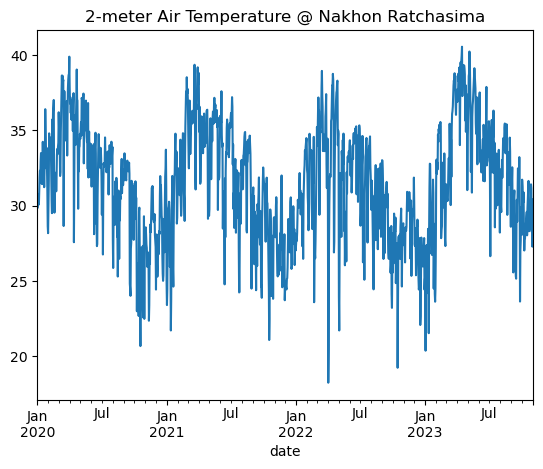

In [7]:
df['max'].plot(title='2-meter Air Temperature @ Nakhon Ratchasima')
plt.show()

In [8]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

In [9]:
training_data = ListDataset(
    [{"start": df.index[0], "target": df['max'][: "2023-01-01T00:00:00.000000"]}],
    freq="D"
)

In [10]:
training_data

[{'start': Period('2020-01-01', 'D'),
  'target': array([29.854258, 29.858706, 30.73062 , ..., 24.418163, 25.080515,
         25.359524], dtype=float32)}]

In [11]:
entry = next(iter(training_data))
train_series = to_pandas(entry)

In [12]:
train_series

2020-01-01    29.854258
2020-01-02    29.858706
2020-01-03    30.730619
2020-01-04    30.227966
2020-01-05    30.071949
                ...    
2022-12-28    27.365028
2022-12-29    27.843164
2022-12-30    24.418163
2022-12-31    25.080515
2023-01-01    25.359524
Freq: D, Length: 1097, dtype: float32

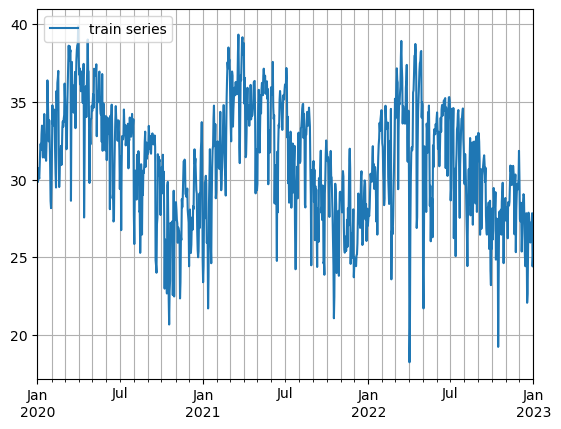

In [13]:
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [14]:
len(train_series)

1097

In [15]:
# Test data
test_data = ListDataset(
    [{"start": df.index[0], "target": df['max'][:"2023-11-03T00:00:00.000000"]}],
    freq = "D"
)

In [16]:
index_train_end = df.index.get_loc('2023-01-01')

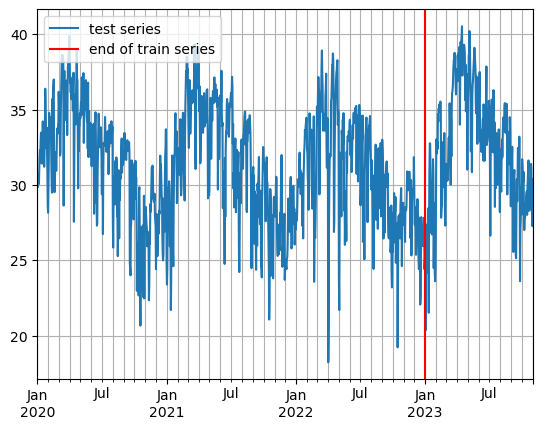

In [17]:
entry = next(iter(test_data))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(df.index[index_train_end], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [18]:
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

In [19]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]

In [20]:
len(test_series)-len(train_series)

306

In [21]:
estimator = DeepAREstimator(
    freq="D",
    prediction_length=306,
    context_length=1.5*306,
    num_layers = 2,
    num_cells = 40,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=100,
                    callbacks=callbacks))

In [22]:
%%time
predictor = estimator.train(training_data)

100%|██████████| 50/50 [01:13<00:00,  1.48s/it, epoch=100/100, avg_epoch_loss=1.06]


CPU times: user 1h 42min 17s, sys: 50.3 s, total: 1h 43min 7s
Wall time: 2h 3min 43s


In [23]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [24]:
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

In [25]:
forecast_entry

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[25.31675  , 26.442316 , 25.887312 , ..., 16.665297 , 16.370623 ,
        15.8469925],
       [25.418974 , 26.410164 , 25.422955 , ..., 16.799206 , 16.327593 ,
        15.872728 ],
       [25.556387 , 26.612284 , 25.817162 , ..., 16.502708 , 16.548344 ,
        15.821284 ],
       ...,
       [25.933968 , 26.67682  , 25.875763 , ..., 16.40686  , 16.518064 ,
        15.752458 ],
       [25.33565  , 26.240164 , 25.655787 , ..., 16.687153 , 15.9546995,
        15.564869 ],
       [25.259789 , 26.238737 , 25.871302 , ..., 16.569572 , 16.403824 ,
        15.750861 ]], dtype=float32), start_date=Period('2023-01-02', 'D'))

In [26]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = len(test_series)
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.axvline(df.index[index_train_end], color='r') # end of train dataset
    plt.grid(which="both")
    plt.legend(legend, loc="lower left")
    plt.show()

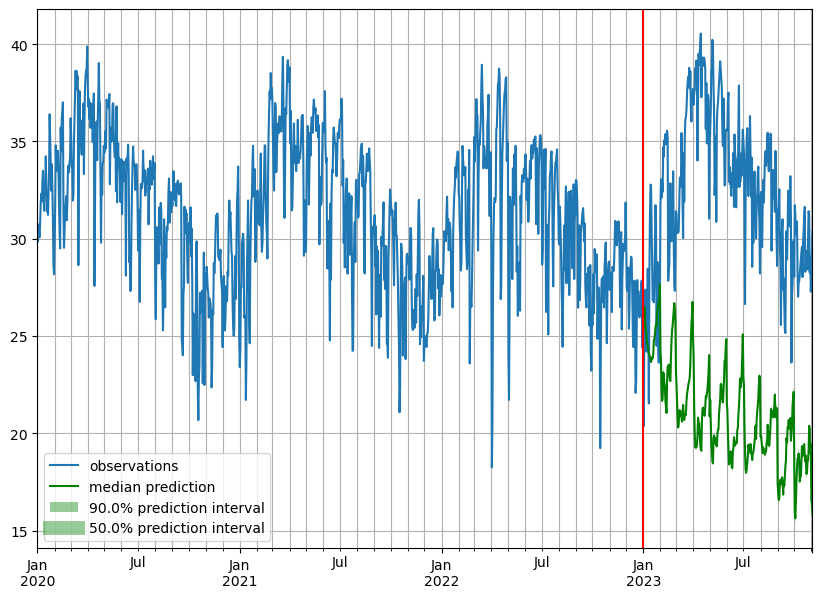

In [27]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [28]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))
import json
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


{
    "MSE": 157.22077971813727,
    "abs_error": 3585.78076171875,
    "abs_target_sum": 9977.369140625,
    "abs_target_mean": 32.60578150531046,
    "seasonal_error": 1.508447354727418,
    "MASE": 7.768410177968814,
    "MAPE": 0.35017434911790235,
    "sMAPE": 0.43450962640101615,
    "MSIS": 305.8545603232874,
    "QuantileLoss[0.1]": 750.4381465911865,
    "Coverage[0.1]": 0.029411764705882353,
    "QuantileLoss[0.2]": 1463.390089416504,
    "Coverage[0.2]": 0.029411764705882353,
    "QuantileLoss[0.3]": 2173.303147315979,
    "Coverage[0.3]": 0.029411764705882353,
    "QuantileLoss[0.4]": 2880.7611236572266,
    "Coverage[0.4]": 0.029411764705882353,
    "QuantileLoss[0.5]": 3585.7810201644897,
    "Coverage[0.5]": 0.029411764705882353,
    "QuantileLoss[0.6]": 4289.097135162354,
    "Coverage[0.6]": 0.029411764705882353,
    "QuantileLoss[0.7]": 4988.215001869201,
    "Coverage[0.7]": 0.029411764705882353,
    "QuantileLoss[0.8]": 5681.976014709473,
    "Coverage[0.8]": 0.0294

In [30]:
from prophet import Prophet

In [31]:
m = Prophet()